In [28]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D


np.random.seed(0)

# Creating the Dataset

In [29]:
def create_data(points, classes): # Creates a dataset of spiral shaped clusters
    X = np.zeros((points * classes, 2))
    y = np.zeros(points * classes, dtype='uint8')

    for class_number in range(classes):
        ix = range(points * class_number,
                   points * (class_number + 1))
        r = np.linspace(0.0, 1, points)  # radius
        t = np.linspace(class_number * 4,
                        (class_number + 1) * 4,
                        points) + np.random.randn(points) * 0.2
        X[ix] = np.c_[r * np.sin(t * 2.5),
                      r * np.cos(t * 2.5)]
        y[ix] = class_number

    return X, y

X,Y = create_data(100,3)

# Layers

In [30]:
class Neuron_Layer():
    def __init__(self, n_inputs,n_neurons):
        self.weights = 0.1*np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1,n_neurons))
        pass

    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights)+self.biases
        pass
    
    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

# Activation Functions

In [31]:
class Activation_ReLU():
    def forward(self,inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
        
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [32]:
class Activation_Softmax():
    def forward(self,inputs):
        exps = np.exp(inputs - np.max(inputs,axis=1,keepdims=True))
        normalised = exps / np.sum(exps,axis=1,keepdims=True)
        self.output = normalised
    
    def backward(self,dvalues): 
        # TODO Reread 216-225
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output,single_dvalues) in enumerate(zip(self.output,dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
                              
            # Calculate sample-wise gradient.
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

# Optimizers

In [33]:
class Optimizer_SGD:
    def __init__(self,learning_rate=1.0):
        self.learning_rate=learning_rate
    
    def update_params(self,layer : Neuron_Layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

# Loss

In [34]:
class Loss:
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [35]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred,1e-7,1-1e-7)
        
        if len(y_true.shape)==1: # Labels are class indicies
            correct_confidences = y_pred_clipped[range(samples),y_true]
        elif len(y_true.shape)==2: # One hot encoding
            correct_confidences = np.sum(y_pred_clipped*y_true,axis=1)
        
        loss = -np.log(correct_confidences)
        return loss
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape)==1:
            # If it is sparse, convert to one-hot
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true/dvalues # Calculate gradient
        self.dinputs = self.dinputs/samples # Normalize gradient

Below is a combined implementation of the softmax activation function and the Categorical Crossentropy loss function, which is more optimal.

In [36]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output,y_true)
    
    def backward(self,dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape)==2: # If one hot, turn it into sparse (discrete)
            y_true = np.argmax(y_true,axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -=1
        self.dinputs = self.dinputs / samples 

# Spiral dataset
In the below cells I will attempt to create and train a neural network on the spiral dataset created in cell 2.

In [37]:
# Defining the structure of the network


layer1 = Neuron_Layer(2,64)
activation1 = Activation_ReLU()

layer2 = Neuron_Layer(64,3) # Output layer
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD(learning_rate=0.1)

In [38]:
# Forward pass
layer1.forward(X)
activation1.forward(layer1.output)

layer2.forward(activation1.output)
loss = loss_activation.forward(layer2.output, Y)

predictions = np.argmax(loss_activation.output,axis=1)
y = Y.copy()
if len(y.shape) == 2:
    y = np.argmax(Y, axis=1)
accuracy = np.mean(predictions==y)
print('loss:', loss)
print('acc:', accuracy)



loss: 1.096954255394673
acc: 0.36




## Backward Pass: Softmax + Categorical Crossentropy

The backward pass through the **softmax** and **categorical crossentropy loss** can be implemented in two different ways.

---

### **Combined Implementation (Recommended)**

This approach fuses the softmax activation and categorical crossentropy loss into a single backward pass.
It is **computationally more efficient** and **numerically stable**.

```python
softmax_loss = Activation_Softmax_Loss_CategoricalCrossentropy()
softmax_loss.backward(activation2.output, Y)
dvalues1 = softmax_loss.dinputs
```

---

### **Separate Implementation (Less Optimal)**

This approach computes the backward pass for the loss and activation **independently**, resulting in extra computation.

```python
activation = Activation_Softmax()
activation.output = activation2.output

loss = Loss_CategoricalCrossentropy()
loss.backward(activation2.output, Y)

activation.backward(loss.dinputs)
dvalues2 = activation.dinputs
```



In [39]:
loss_activation.backward(loss_activation.output, Y)
layer2.backward(loss_activation.dinputs)
activation1.backward(layer2.dinputs)
layer1.backward(activation1.dinputs)



print(layer1.dweights)
print(layer1.dbiases)
print(layer2.dweights)
print(layer2.dbiases)

optimizer.update_params(layer1)
optimizer.update_params(layer2)

[[ 2.60353485e-04  8.21591718e-04  1.64856392e-03  1.56066659e-04
   3.01920954e-04 -4.11998028e-04 -1.18409140e-03  5.74029975e-04
  -2.35125433e-06 -4.39047351e-03 -5.54947268e-04  5.71098071e-04
   6.06602842e-04  1.01263125e-03  1.43516850e-03  2.61695293e-03
   1.07257656e-03  2.91578689e-04  7.49834200e-04 -1.67464087e-04
  -5.91174645e-04  1.50413433e-03  1.24583758e-04  4.37889165e-04
  -8.22745084e-05 -3.29320089e-04  2.80925560e-04  4.27853738e-05
   3.60705206e-04  5.78682263e-04 -4.86213290e-04 -1.74072340e-04
   1.85531839e-05 -2.68101935e-03  3.70008477e-03 -2.27912662e-04
   5.71246726e-05 -1.50773870e-03  1.23636026e-03 -9.59831504e-04
   3.64413246e-04  1.47144837e-04  1.26062018e-03 -8.25836713e-04
  -1.59421414e-03  1.39595074e-03 -2.86759415e-04 -1.62456500e-03
   8.16717256e-05 -1.00062355e-04  1.45611067e-03  7.60009919e-04
   1.64431820e-04 -2.44547569e-03 -1.11016325e-04  2.31122372e-03
  -2.49965821e-04 -1.18413571e-03 -3.29019918e-04 -4.84269614e-04
  -8.53349

# Learning with the SGD optimizer

In [40]:
for epoch in range(50001):
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    loss = loss_activation.forward(layer2.output, Y)
    predictions = np.argmax(loss_activation.output,axis=1)
    accuracy = np.mean(predictions==Y)
    
    if epoch%5000==0:
        print(f"Epoch: {epoch} | acc: {accuracy:.3f} | loss: {loss:.3f}")
    
    loss_activation.backward(loss_activation.output, Y)
    layer2.backward(loss_activation.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)

Epoch: 0 | acc: 0.360 | loss: 1.097
Epoch: 5000 | acc: 0.420 | loss: 1.050
Epoch: 10000 | acc: 0.620 | loss: 0.943
Epoch: 15000 | acc: 0.683 | loss: 0.820
Epoch: 20000 | acc: 0.633 | loss: 0.795
Epoch: 25000 | acc: 0.637 | loss: 0.780
Epoch: 30000 | acc: 0.637 | loss: 0.797
Epoch: 35000 | acc: 0.627 | loss: 0.815
Epoch: 40000 | acc: 0.683 | loss: 0.755
Epoch: 45000 | acc: 0.657 | loss: 0.751
Epoch: 50000 | acc: 0.730 | loss: 0.668


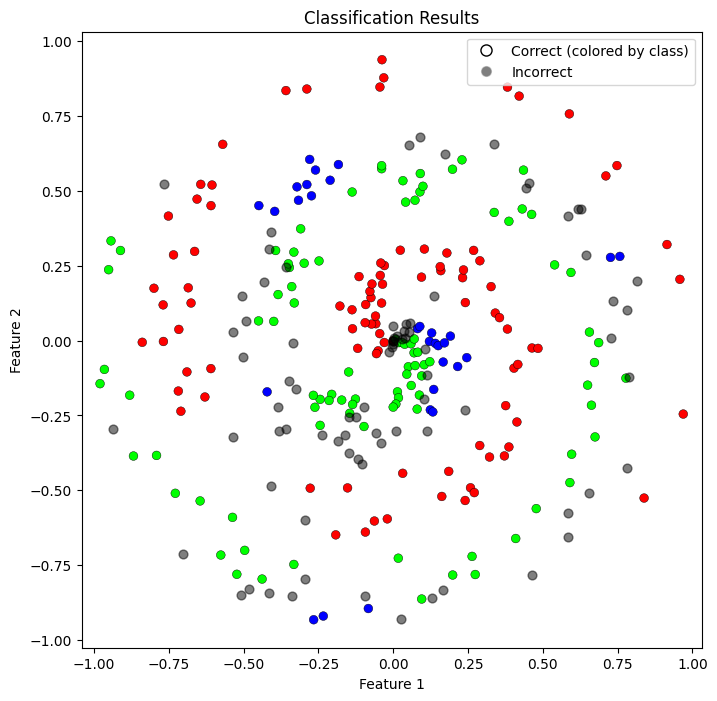

In [43]:
correct = predictions == Y
incorrect = ~correct

plt.figure(figsize=(8, 8))

# Correct classifications (colored by class)
plt.scatter(
    X[correct, 0],
    X[correct, 1],
    c=Y[correct],
    cmap='brg',
    s=40,
    edgecolors='k',
    linewidths=0.3
)

# Incorrect classifications (black, semi-transparent)
plt.scatter(
    X[incorrect, 0],
    X[incorrect, 1],
    c='black',
    alpha=0.5,
    s=40
)

# Custom legend (fixes color mismatch)
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='white', markeredgecolor='black',
           markersize=8, label='Correct (colored by class)'),
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='black', alpha=0.5,
           markersize=8, label='Incorrect')
]

plt.legend(handles=legend_elements)

plt.title("Classification Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis('equal')
plt.savefig("./demo/spiralClassification.png", dpi=300, bbox_inches="tight")
plt.show()